<a href="https://colab.research.google.com/github/benliao/gameai_notebook/blob/main/functional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# The Functional API

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

The Keras *functional API* is a way to create models that are more flexible
than the `tf.keras.Sequential` API. The functional API can handle models
with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually
a directed acyclic graph (DAG) of layers.
So the functional API is a way to build *graphs of layers*.

Consider the following model:

```
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)
```

This is a basic graph with three layers.
To build this model using the functional API, start by creating an input node:

In [ ]:
inputs = keras.Input(shape=(784,))

In [ ]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")


The shape of the data is set as a 784-dimensional vector.
The batch size is always omitted since only the shape of each sample is specified.

If, for example, you have an image input with a shape of `(32, 32, 3)`,
you would use:

In [ ]:
# Just for demonstration purposes.
img_inputs = keras.Input(shape=(32, 32, 3))

In [ ]:
img_inputs.shape

TensorShape([None, 32, 32, 3])

In [ ]:
img_inputs.dtype

tf.float32

The `inputs` that is returned contains information about the shape and `dtype`
of the input data that you feed to your model.
Here's the shape:

In [ ]:
inputs.shape

TensorShape([None, 784])

Here's the dtype:

In [ ]:
inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this `inputs`
object:

In [ ]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

In [ ]:
print(dense)

In [ ]:
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='dense_13/Relu:0', description="created by layer 'dense_13'")


The "layer call" action is like drawing an arrow from "inputs" to this layer
you created.
You're "passing" the inputs to the `dense` layer, and you get `x` as the output.

Let's add a few more layers to the graph of layers:

In [ ]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

At this point, you can create a `Model` by specifying its inputs and outputs
in the graph of layers:

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

Let's check out what the model summary looks like:

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


You can also plot the model as a graph:

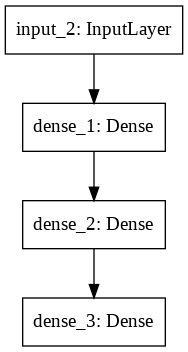

In [ ]:
keras.utils.plot_model(model, "my_first_model.png")

And, optionally, display the input and output shapes of each layer
in the plotted graph:

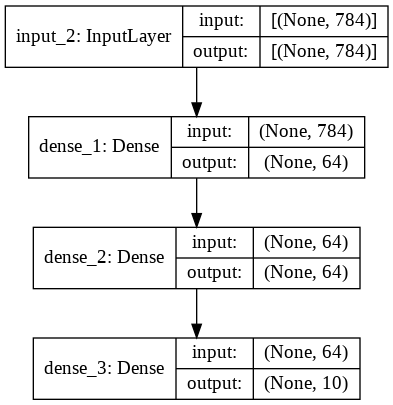

In [ ]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

This figure and the code are almost identical. In the code version,
the connection arrows are replaced by the call operation.

A "graph of layers" is an intuitive mental image for a deep learning model,
and the functional API is a way to create models that closely mirrors this.

## Training, evaluation, and inference

Training, evaluation, and inference work exactly in the same way for models
built using the functional API as for `Sequential` models.

The `Model` class offers a built-in training loop (the `fit()` method)
and a built-in evaluation loop (the `evaluate()` method). Note
that you can easily [customize these loops](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)
to implement training routines beyond supervised learning
(e.g. [GANs](/examples/generative/dcgan_overriding_train_step/)).

Here, load the MNIST image data, reshape it into vectors,
fit the model on the data (while monitoring performance on a validation split),
then evaluate the model on the test data:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.3413 - accuracy: 0.9020 - val_loss: 0.1856 - val_accuracy: 0.9451
Epoch 2/2
750/750 [==============================] - 2s 3ms/step - loss: 0.1645 - accuracy: 0.9514 - val_loss: 0.1393 - val_accuracy: 0.9592
313/313 - 0s - loss: 0.1372 - accuracy: 0.9588
Test loss: 0.13723063468933105
Test accuracy: 0.9588000178337097


For further reading, see the [training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate/) guide.

## Save and serialize

Saving the model and serialization work the same way for models built using
the functional API as they do for `Sequential` models. The standard way
to save a functional model is to call `model.save()`
to save the entire model as a single file. You can later recreate the same model
from this file, even if the code that built the model is no longer available.

This saved file includes the:
- model architecture
- model weight values (that were learned during training)
- model training config, if any (as passed to `compile`)
- optimizer and its state, if any (to restart training where you left off)

In [ ]:
model.save("path_to_my_model")
del model
# Recreate the exact same model purely from the file:
model = keras.models.load_model("path_to_my_model")

For details, read the model [serialization & saving](
https://www.tensorflow.org/guide/keras/save_and_serialize/) guide.

## Use the same graph of layers to define multiple models

In the functional API, models are created by specifying their inputs
and outputs in a graph of layers. That means that a single
graph of layers can be used to generate multiple models.

In the example below, you use the same stack of layers to instantiate two models:
an `encoder` model that turns image inputs into 16-dimensional vectors,
and an end-to-end `autoencoder` model for training.

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Here, the decoding architecture is strictly symmetrical
to the encoding architecture, so the output shape is the same as
the input shape `(28, 28, 1)`.

The reverse of a `Conv2D` layer is a `Conv2DTranspose` layer,
and the reverse of a `MaxPooling2D` layer is an `UpSampling2D` layer.

## All models are callable, just like layers

You can treat any model as if it were a layer by invoking it on an `Input` or
on the output of another layer. By calling a model you aren't just reusing
the architecture of the model, you're also reusing its weights.

To see this in action, here's a different take on the autoencoder example that
creates an encoder model, a decoder model, and chains them in two calls
to obtain the autoencoder model:

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

As you can see, the model can be nested: a model can contain sub-models
(since a model is just like a layer).
A common use case for model nesting is *ensembling*.
For example, here's how to ensemble a set of models into a single model
that averages their predictions:

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 1)            129         input_12[0][0]                   
__________________________________________________________________________________________________
model_9 (Functional)            (None, 1)            129         input_12[0][0]                   
__________________________________________________________________________________________________
model_10 (Functional)           (None, 1)            129         input_12[0][0]                   
___________________________________________________________________________________________

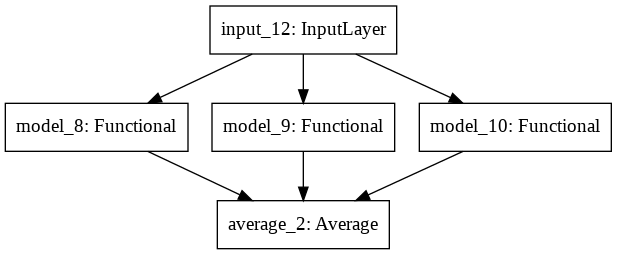

In [ ]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

ensemble_model.summary()

keras.utils.plot_model(ensemble_model)

## Manipulate complex graph topologies

### Models with multiple inputs and outputs

The functional API makes it easy to manipulate multiple inputs and outputs.
This cannot be handled with the `Sequential` API.

For example, if you're building a system for ranking customer issue tickets by
priority and routing them to the correct department,
then the model will have three inputs:

- the title of the ticket (text input),
- the text body of the ticket (text input), and
- any tags added by the user (categorical input)

This model will have two outputs:

- the priority score between 0 and 1 (scalar sigmoid output), and
- the department that should handle the ticket (softmax output
over the set of departments).

You can build this model in a few lines with the functional API:

In [ ]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

shared_embedding=layers.Embedding(num_words, 64)

# Embed each word in the title into a 64-dimensional vector
#title_features = layers.Embedding(num_words, 64)(title_input)
title_features = shared_embedding(title_input)
# Embed each word in the text into a 64-dimensional vector
#body_features = layers.Embedding(num_words, 64)(body_input)
body_features = shared_embedding(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

Now plot the model:

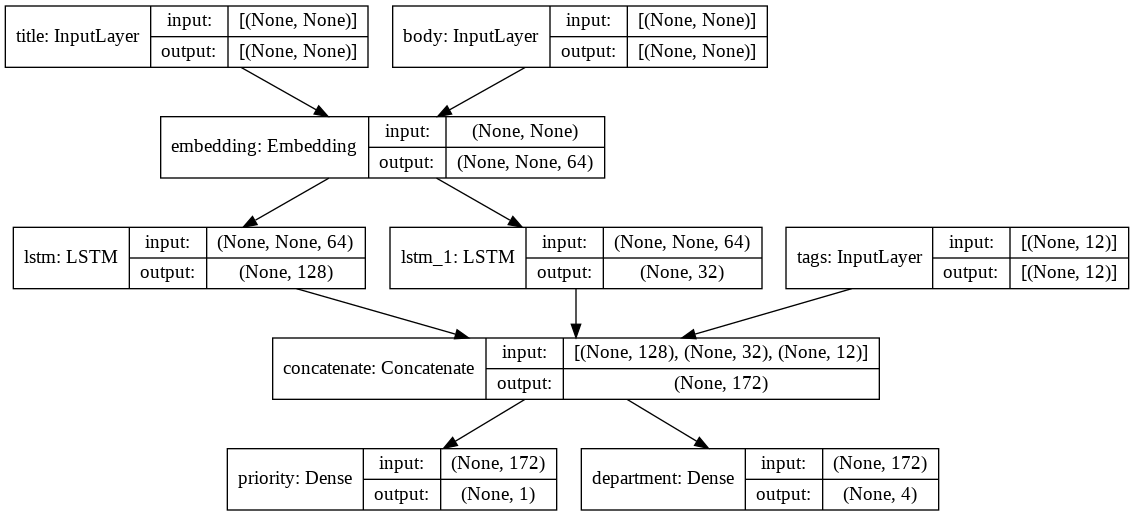

In [ ]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

When compiling this model, you can assign different losses to each output.
You can even assign different weights to each loss -- to modulate
their contribution to the total training loss.

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

Since the output layers have different names, you could also specify
the losses and loss weights with the corresponding layer names:

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

Train the model by passing lists of NumPy arrays of inputs and targets:

In [ ]:
# Dummy input data
title_data = np.random.randint(num_words, size=(1280, 10))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# Dummy target data
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

When calling fit with a `Dataset` object, it should yield either a
tuple of lists like `([title_data, body_data, tags_data], [priority_targets, dept_targets])`
or a tuple of dictionaries like
`({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`.

For more detailed explanation, refer to the [training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate/) guide.

### A toy ResNet model

In addition to models with multiple inputs and outputs,
the functional API makes it easy to manipulate non-linear connectivity
topologies -- these are models with layers that are not connected sequentially,
which the `Sequential` API cannot handle.

A common use case for this is residual connections.
Let's build a toy ResNet model for CIFAR10 to demonstrate this:

In [ ]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Plot the model:

In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

Now train the model:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# We restrict the data to the first 1000 samples so as to limit execution time
# on Colab. Try to train on the entire dataset until convergence!
model.fit(x_train[:1000], y_train[:1000], batch_size=64, epochs=1, validation_split=0.2)

## Shared layers

Another good use for the functional API are models that use *shared layers*.
Shared layers are layer instances that are reused multiple times in the same model --
they learn features that correspond to multiple paths in the graph-of-layers.

Shared layers are often used to encode inputs from similar spaces
(say, two different pieces of text that feature similar vocabulary).
They enable sharing of information across these different inputs,
and they make it possible to train such a model on less data.
If a given word is seen in one of the inputs,
that will benefit the processing of all inputs that pass through the shared layer.

To share a layer in the functional API, call the same layer instance multiple times.
For instance, here's an `Embedding` layer shared across two different text inputs:

In [ ]:
# Embedding for 1000 unique words mapped to 128-dimensional vectors
shared_embedding = layers.Embedding(1000, 128)

# Variable-length sequence of integers
text_input_a = keras.Input(shape=(None,), dtype="int32")

# Variable-length sequence of integers
text_input_b = keras.Input(shape=(None,), dtype="int32")

# Reuse the same layer to encode both inputs
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)


## Extract and reuse nodes in the graph of layers

Because the graph of layers you are manipulating is a static data structure,
it can be accessed and inspected. And this is how you are able to plot
functional models as images.

This also means that you can access the activations of intermediate layers
("nodes" in the graph) and reuse them elsewhere --
which is very useful for something like feature extraction.

Let's look at an example. This is a VGG19 model with weights pretrained on ImageNet:

In [2]:
vgg19 = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 4s 0us/step


And these are the intermediate activations of the model,
obtained by querying the graph data structure:

In [24]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

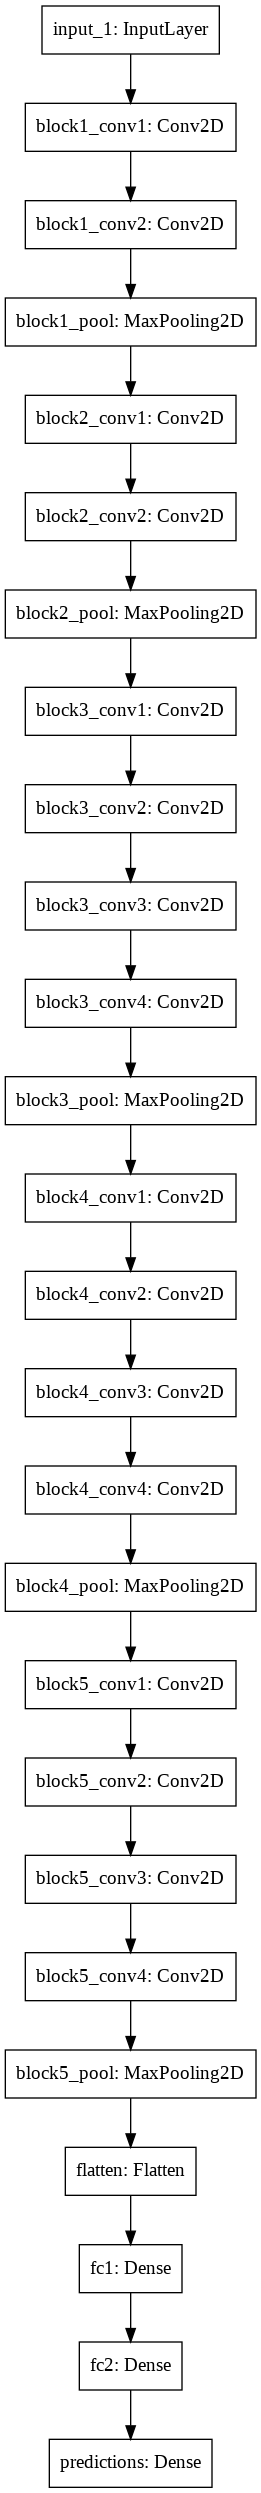

In [4]:
keras.utils.plot_model(vgg19, "vgg19.png")

In [15]:
features_list = [layer.output for layer in vgg19.layers]

In [25]:
print(features_list)

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>, <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>, <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>, <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>, <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>, <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>, <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>, <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv4')>, <KerasTen

Use these features to create a new feature-extraction model that returns
the values of the intermediate layer activations:

In [30]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

In [31]:
feat_extraction_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

This comes in handy for tasks like
[neural style transfer](https://keras.io/examples/generative/neural_style_transfer/),
among other things.

## Extend the API using custom layers

`tf.keras` includes a wide range of built-in layers, for example:

- Convolutional layers: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`
- Pooling layers: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`
- RNN layers: `GRU`, `LSTM`, `ConvLSTM2D`
- `BatchNormalization`, `Dropout`, `Embedding`, etc.

But if you don't find what you need, it's easy to extend the API by creating
your own layers. All layers subclass the `Layer` class and implement:

- `call` method, that specifies the computation done by the layer.
- `build` method, that creates the weights of the layer (this is just a style
convention since you can create weights in `__init__`, as well).

To learn more about creating layers from scratch, read
[custom layers and models](https://www.tensorflow.org/guide/keras/custom_layers_and_models) guide.

The following is a basic implementation of `tf.keras.layers.Dense`:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

For serialization support in your custom layer, define a `get_config`
method that returns the constructor arguments of the layer instance:

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self): 
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

Optionally, implement the class method `from_config(cls, config)` which is used
when recreating a layer instance given its config dictionary.
The default implementation of `from_config` is:

```python
def from_config(cls, config):
  return cls(**config)
```

## When to use the functional API

Should you use the Keras functional API to create a new model,
or just subclass the `Model` class directly? In general, the functional API
is higher-level, easier and safer, and has a number of
features that subclassed models do not support.

However, model subclassing provides greater flexibility when building models
that are not easily expressible as directed acyclic graphs of layers.
For example, you could not implement a Tree-RNN with the functional API
and would have to subclass `Model` directly.

For an in-depth look at the differences between the functional API and
model subclassing, read
[What are Symbolic and Imperative APIs in TensorFlow 2.0?](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html).

### Functional API strengths:

The following properties are also true for Sequential models
(which are also data structures), but are not true for subclassed models
(which are Python bytecode, not data structures).

#### Less verbose

There is no `super(MyClass, self).__init__(...)`, no `def call(self, ...):`, etc.

Compare:

```python
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)
```

With the subclassed version:

```python
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))
```

#### Model validation while defining its connectivity graph

In the functional API, the input specification (shape and dtype) is created
in advance (using `Input`). Every time you call a layer,
the layer checks that the specification passed to it matches its assumptions,
and it will raise a helpful error message if not.

This guarantees that any model you can build with the functional API will run.
All debugging -- other than convergence-related debugging --
happens statically during the model construction and not at execution time.
This is similar to type checking in a compiler.

#### A functional model is plottable and inspectable

You can plot the model as a graph, and you can easily access intermediate nodes
in this graph. For example, to extract and reuse the activations of intermediate
layers (as seen in a previous example):

```python
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```

#### A functional model can be serialized or cloned

Because a functional model is a data structure rather than a piece of code,
it is safely serializable and can be saved as a single file
that allows you to recreate the exact same model
without having access to any of the original code.
See the [serialization & saving guide](https://www.tensorflow.org/guide/keras/save_and_serialize/).

To serialize a subclassed model, it is necessary for the implementer
to specify a `get_config()`
and `from_config()` method at the model level.


### Functional API weakness:

#### It does not support dynamic architectures

The functional API treats models as DAGs of layers.
This is true for most deep learning architectures, but not all -- for example,
recursive networks or Tree RNNs do not follow this assumption and cannot
be implemented in the functional API.

## Mix-and-match API styles

Choosing between the functional API or Model subclassing isn't a
binary decision that restricts you into one category of models.
All models in the `tf.keras` API can interact with each other, whether they're
`Sequential` models, functional models, or subclassed models that are written
from scratch.

You can always use a functional model or `Sequential` model
as part of a subclassed model or layer:

In [ ]:
units = 32
timesteps = 10
input_dim = 5

# Define a Functional model
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # Our previously-defined Functional model
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, timesteps, input_dim)))

You can use any subclassed layer or model in the functional API
as long as it implements a `call` method that follows one of the following patterns:

- `call(self, inputs, **kwargs)` --
Where `inputs` is a tensor or a nested structure of tensors (e.g. a list of tensors),
and where `**kwargs` are non-tensor arguments (non-inputs).
- `call(self, inputs, training=None, **kwargs)` --
Where `training` is a boolean indicating whether the layer should behave
in training mode and inference mode.
- `call(self, inputs, mask=None, **kwargs)` --
Where `mask` is a boolean mask tensor (useful for RNNs, for instance).
- `call(self, inputs, training=None, mask=None, **kwargs)` --
Of course, you can have both masking and training-specific behavior at the same time.

Additionally, if you implement the `get_config` method on your custom Layer or model,
the functional models you create will still be serializable and cloneable.

Here's a quick example of a custom RNN, written from scratch,
being used in a functional model:

In [ ]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super(CustomRNN, self).__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = tf.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = tf.stack(outputs, axis=1)
        return self.classifier(features)


# Note that you specify a static batch size for the inputs with the `batch_shape`
# arg, because the inner computation of `CustomRNN` requires a static batch size
# (when you create the `state` zeros tensor).
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(tf.zeros((1, 10, 5)))